In [1]:
from matplotlib import animation, rc, pyplot as plt
import pickle
import os
import shutil
from scipy import interpolate, signal, linalg, spatial
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, accuracy_score
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering, KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from numba import cuda, jit, njit, prange, vectorize
import networkx as nx
import grakel
import netlsd
from collections import defaultdict, Counter
from itertools import combinations, product
import pandas as pd
import numpy as np
import math
import cv2
import copy
from multiprocessing import cpu_count
from joblib import Parallel, delayed, pool
from IPython.display import clear_output, HTML
from IPython.core.debugger import set_trace
import torch
from tqdm import tqdm_notebook
N_CPU = cpu_count()
TOY_DATASET = False


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.lfw module

In [154]:
ls -la data/Circle/spikes

total 196480
drwxrwxr-x 2 ibulygin ibulygin     4096 фев 18 17:15 ./
drwxrwxr-x 4 ibulygin ibulygin     4096 фев 18 17:16 ../
-rw-rw-r-- 1 ibulygin ibulygin 41802027 ноя 20  2020 CA1_22_1D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin 35815521 ноя 20  2020 CA1_22_2D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin 18653103 ноя 20  2020 CA1_22_3D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin 16706911 ноя 20  2020 CA1_23_1D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin 10855226 ноя 20  2020 CA1_23_2D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin 12262724 ноя 20  2020 CA1_23_3D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin  6400647 ноя 20  2020 CA1_24_1D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin  8138397 ноя 20  2020 CA1_24_2D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin  9015290 ноя 20  2020 CA1_24_3D_initial_data_spikes.csv
-rw-rw-r-- 1 ibulygin ibulygin 20715113 ноя 20  2020 CA1_25_1D_initial_data_spikes.csv
-rw-

In [174]:
# CA1_match = pd.read_csv(f'CA_Match/CA1_{mouse}_match.csv', header=None)

# Create toy dataset

In [2]:
# TOY_DATASET = True

# toy_steps_per_round = 1000
# dphi = 2*np.pi/toy_steps_per_round
# toy_neurons_per_place = 10
# toy_n_places = 4
# toy_timesteps = 5000
# toy_spdata = np.zeros((toy_n_places*toy_neurons_per_place, toy_timesteps))
# toy_phi = []

# for i in range(toy_timesteps):
#     j = i%(toy_steps_per_round) # index within round 
#     step = dphi*j
#     toy_phi.append(step)
#     # number of place
#     k = int(j//(toy_steps_per_round//toy_n_places))
    
#     if i%25==0 and j%(toy_steps_per_round//toy_n_places) != 0:
#         for m,random_offset in enumerate(np.random.choice(np.arange(-3,4), size=toy_neurons_per_place)):
#             toy_spdata[min(toy_neurons_per_place*toy_n_places - 1, (k*toy_neurons_per_place)+m),
#                        i+random_offset] = 1.
    
# toy_phi = np.array(toy_phi) #- np.pi
# x_toy = np.cos(toy_phi)
# y_toy = np.sin(toy_phi)

# plt.figure()
# plt.scatter(x_toy, y_toy, c=toy_phi)
# plt.show()

In [3]:
# fig, axes = plt.subplots(ncols=5, nrows=10, figsize=(5*10,10*10))
# for k,ax in enumerate(axes.flatten()):
#         ax.imshow(toy_spdata[:,100*k:100*(k+1)])

In [4]:
if TOY_DATASET:
    spdata = toy_spdata
    phi = toy_phi
    coords_ = np.stack([x_toy, y_toy],1)
    N, T = spdata.shape

# Real data

In [5]:
track = 'Circle'
mouse = 22
day = 1
calcium_df = pd.read_csv(f"./data/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
spikes_df = pd.read_csv(f"./data/{track}/spikes/CA1_{mouse}_{day}D_initial_data_spikes.csv", index_col=0)
rears_events = pd.read_csv(f'./data/CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv', index_col=0)

trim=100
cadata = calcium_df.iloc[:,7:][trim:-trim].T.values # [n_neurons, T] 
spdata = spikes_df.iloc[:,1:][trim:-trim].T.values # [n_neurons, T]
rears_events = rears_events[trim:-trim]

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values

cells_with_spikes = np.sum(spdata, axis = 1) > 1.

spdata = spdata[cells_with_spikes]
cadata = cadata[cells_with_spikes]

N, T = spdata.shape

# scaler = MinMaxScaler()
# spdata = scaler.fit_transform(spdata)
# cadata = scaler.fit_transform(cadata)

coords = calcium_df[['x','y']][trim:-trim].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)

phi = np.arctan2(coords_[:,1], coords_[:,0])
phi[phi < 0] = 2*np.pi + phi[phi < 0]

# # speed sign
dphi = np.diff(phi, prepend=phi[0])
jump_mask = np.abs(dphi) > 6 # jump through breakpoint
dphi[jump_mask] = -1 * np.sign(dphi[jump_mask]) * np.abs(dphi[jump_mask] - 2*np.pi)
circle_sign = np.sign(dphi)

# speed
shift = np.diff(coords_, prepend=[coords_[0]], axis=0)
speed = np.sqrt((shift**2).sum(1)) * circle_sign

# acceleration
acceleration = np.diff(speed, prepend=speed[0])

acceleration_ = MinMaxScaler((0,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_,
    'phi': phi
}

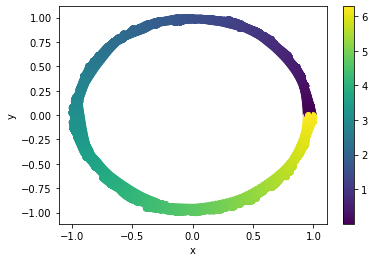

In [6]:
plt.scatter(coords_[:,0], coords_[:,1], c=phi)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [7]:
# plt.hist(spdata.flatten(), bins=100)
# plt.yscale('log')
# plt.show()

# Load real data

In [8]:
# x = np.linspace(0, 400, num = 400)
# sp = spike_form(x)

# plt.figure()
# plt.plot(sp)
# plt.title('Spike kernel')
# plt.show()

# denoised_data = spdata.copy()[:,:2500]
# denoised_data[0,:] = np.convolve(denoised_data[0,:], sp)[:-400+1]

# fig, ax = plt.subplots(figsize = (16,12))
# ax.plot(cadata[0,:2500]/max(cadata[0,:2500]), c = 'b', linewidth = 4)
# ax.plot(spdata[0,:2500]/max(spdata[0,:2500]), c = 'r', linewidth = 4)
# ax.plot(denoised_data[0], c = 'y', linewidth = 4)# /max(denoised_data[0])

In [9]:
# mu = np.mean(n_spikes_per_windos).astype(int)
# plt.hist(n_spikes_per_windos, bins=100)
# # plt.yscale('log')
# plt.show()
# print(mu)

In [22]:
# make torch kernel
T_RISE = 5 # 15 for orig, 5 for toy
T_OFF = 5 # 40 for orig, 5 for toy

SYGMA = 7
dt = 100 #window length, 1000 for orig, 100 for toy
WITH_DIAG=False

# spdata_bool = spdata.astype(bool)
# n_spikes_per_windos = []
# for n in tqdm_notebook(range(N)):
#     for i in range(T-dt):
#         s = spdata_bool[n,i:i+dt].sum()
#         if s > 0:
#             n_spikes_per_windos.append(s)
            
kernel_type = 'gaussian' # 'exponential'
kernel_size = 49 #int(dt//(mu)) # 400 for orig, 50 for toy

if kernel_type == 'gaussian':
    assert kernel_size%2==1
    if SYGMA is None:
        sygma = kernel_size//7
    else:
        sygma = SYGMA
    sp = signal.gaussian(M=kernel_size, std=sygma)

elif kernel_type == 'exponential':
    def spike_form(t):
        return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)
    x = np.linspace(0, kernel_size, num = kernel_size)
    sp = spike_form(x)[::-1].copy()

sp_torch = torch.tensor(sp).float().cuda()
sp_torch_batch = sp_torch.unsqueeze(0).unsqueeze(0)
spdata_torch = torch.tensor(spdata).float().cuda()

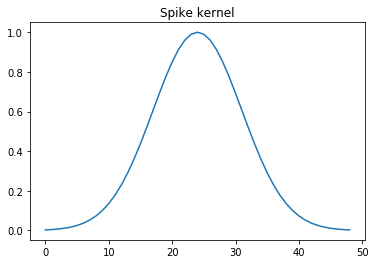

In [23]:
plt.plot(sp_torch_batch[0,0].cpu().numpy())
# plt.plot([0]*dt)
plt.title('Spike kernel')
plt.show()

In [24]:
# result_torch = torch.conv1d(input=spdata_torch.unsqueeze(1), weight=sp_torch_batch, padding=kernel_size//2).squeeze(1)#[:,:dt]
# n=N//2
# fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(50,20), dpi=300)
# for i in range(5):
#     axes[0,i].imshow(spdata[:n,n*i:n*(i+1)].astype(bool))
#     axes[1,i].imshow(result_torch[:n,n*i:n*(i+1)].detach().cpu().numpy())
# plt.show()

In [25]:
# inpt = torch.zeros((2,dt)).cuda() #spdata_torch[:,:dt]
# inpt[0,dt//2] = 1
# # inpt[0,0] = 1
# # inpt[0,-1] = 1


# inpt[1,(dt//2)+10] = 2
# # inpt[1,0] = 2
# # inpt[1,-1] = 2


# result_torch = torch.conv1d(input=inpt.unsqueeze(1), weight=sp_torch_batch, padding=kernel_size//2).squeeze(1)#[:,:dt]

# plt.plot(inpt[0].cpu().numpy(), c='r')
# plt.plot(inpt[1].cpu().numpy(), c='r')
# plt.plot(result_torch[0].cpu().numpy(), c='y')
# plt.plot(result_torch[1].cpu().numpy(), c='g')
# plt.show()

In [26]:
# corr = result_torch @ result_torch.transpose(0,1)
# norms = torch.norm(result_torch, p=2, dim=1).unsqueeze(1)
# corr = corr / (norms@norms.transpose(0,1) + 1e-10)
# corr

# sm = corr.detach().cpu().numpy()
# sm[sm > 1] = 1
# # delete diagonal
# diag = np.diag(np.diagonal(sm))
# sm = sm - diag
# sm

In [27]:
def calc_spike_similarity_cuda(sp_torch_batch, spdata_torch, save=True, corr_dir=None, i=None, timewise=True, with_diag=True):
    dt = spdata_torch.shape[-1]
    kernel_size = sp_torch_batch.shape[-1]
    n = sp_torch.shape[0]
    result_torch = torch.conv1d(input=spdata_torch.unsqueeze(1), weight=sp_torch_batch, padding=kernel_size//2).squeeze(1)
    
    if timewise:
        result_torch = result_torch - result_torch.mean(1).unsqueeze(1)
        norms = torch.norm(result_torch, p=2, dim=1).unsqueeze(1)
        sim_map = result_torch@result_torch.transpose(0,1) / (norms@norms.transpose(0,1) + 1e-10)
    else:
        result_torch = result_torch - result_torch.mean(0).unsqueeze(0)
        norms = torch.norm(result_torch, p=2, dim=0).unsqueeze(1)
        sim_map = result_torch.transpose(0,1)@result_torch / (norms@norms.transpose(0,1) + 1e-10)
        
    sm = np.abs(sim_map.detach().cpu().numpy())
    
    if not with_diag:
        # delete diagonal
        diag = np.diag(np.diagonal(sm))
        sm = sm - diag
    
    sm[sm > 1] = 1
    # save
    if save:
        path = os.path.join(corr_dir, str(i))
        np.save(path, sm)
        return path
    else:
        return sm

In [29]:
def calculate_rbf_spatial_similarity(X, gamma=0.5):
    '''
    X - [n,d] array
    '''
    n,d = X.shape
    d = np.linalg.norm(X.reshape((n,1,d)) - X.reshape((1,n,d)), axis=-1)**2
    A = np.exp(-gamma*d)
    return A

In [30]:
start = 0
end=T-dt 

name = 'TOY' if TOY_DATASET else f'Circle_M{mouse}_D{day}' + ('_diag' if WITH_DIAG else '')

if kernel_type == 'exponential':
    corr_dir = f'./corrmap_data/corrmaps_' + name +  f'_dt{dt}_{kernel_type}_TRISE{T_RISE}_TOFF{T_OFF}'
    
elif kernel_type == 'gaussian':
    corr_dir = f'./corrmap_data/corrmaps_' + name + f'_dt{dt}_kernel{kernel_size}_{kernel_type}_SYGMA{sygma}' 

REMAKE = False
if REMAKE:
    if os.path.exists(corr_dir):
        print('Removing dir!')
        answer = input()
        if answer == 'yes':
            shutil.rmtree(corr_dir)
    os.makedirs(corr_dir, exist_ok=True)

In [31]:
if REMAKE:
    sim_matrices = Parallel(n_jobs=20, verbose=1)(delayed(calc_spike_similarity_cuda)(sp_torch_batch,
                                                                                     spdata_torch[:,i:i+dt], 
                                                                                     save=True,
                                                                                     corr_dir=corr_dir,
                                                                                     i=i,
                                                                                     with_diag=WITH_DIAG) for i in tqdm_notebook(range(start,end)))
    clear_output()

In [32]:
corr_paths = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])

In [33]:
len(corr_paths), corr_dir

(18475, './corrmap_data/corrmaps_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7')

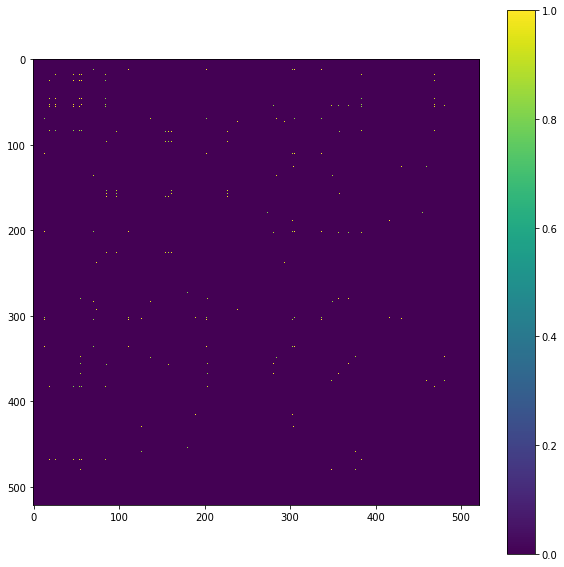

In [34]:
sim = np.load(corr_paths[100])
thr = 0.8
sim_thr = sim.copy()
sim_thr[sim_thr<thr] = 0
plt.figure(figsize=(10,10))
plt.imshow(sim_thr)
plt.colorbar()
plt.show()

# Laplacian

In [35]:
def compute_norm_laplacian_eig(A):
#                              i=None,
#                              normalized=True,
#                              save=False,
#                              savedir=None
    
    # normalized Laplacian
    d = A.sum(0)
    D = np.diag(d)
    L = D - A
    
    if True:# normalized
        D_sqrt_diag = np.sqrt(d)
        D_sqrt_diag[D_sqrt_diag>0] = 1./D_sqrt_diag[D_sqrt_diag>0]
        D_sqrt_diag = np.diag(D_sqrt_diag)
        L = D_sqrt_diag@(L@D_sqrt_diag)
    w,v = np.linalg.eig(L.astype(np.complex64))
    
    return w.real,v.real

@njit
def compute_norm_laplacian(A):    
    # normalized Laplacian
    d = A.sum(0)
    D = np.diag(d)
    L = D - A
    D_sqrt_diag = np.sqrt(d)
    D_sqrt_diag[D_sqrt_diag>0] = 1./D_sqrt_diag[D_sqrt_diag>0]
    D_sqrt_diag = np.diag(D_sqrt_diag)
    L = D_sqrt_diag@(L@D_sqrt_diag)
    return L
    
def get_first_k_eig(w,v,k=5):
    w_argsort = np.argsort(w)
    k_index = w_argsort[:k]
    k_vector = v[:,k_index].real
    return k_vector

def path2keig(p,k=5):
    A = np.load(p)
    return get_first_k_eig(*compute_norm_laplacian_eig(A), k)

In [36]:
# lap_wv_dir = f'./corrmap_data/wv_norm_lap_' + corr_dir.split('/')[-1]

# if os.path.exists(lap_wv_dir):
#     shutil.rmtree(lap_wv_dir)
# os.makedirs(lap_wv_dir, exist_ok=True)

# norm_laplacian_eig_paths = Parallel(n_jobs=-1)(delayed(compute_norm_laplacian_eig)(p,
#                                                                                      i=i,
#                                                                                      save=True,
#                                                                                      normalized=True,
#                                                                                      savedir=lap_wv_dir) for i,p in tqdm_notebook(enumerate(corr_paths)))

In [37]:
# for p in np.random.choice(corr_paths, size=50, replace=False):
#     w,_ = compute_norm_laplacian_eig(p)
#     plt.plot(sorted(w))

In [38]:
# @jit
# def foo(A):
    
#     d = A.sum(0)
#     D_sqrt_diag = np.sqrt(d)
#     L = np.diag(d) - A 
#     D_sqrt_diag[D_sqrt_diag>0] = 1./D_sqrt_diag[D_sqrt_diag>0]
#     D_sqrt_diag = np.diag(D_sqrt_diag)
#     L = D_sqrt_diag@(L@D_sqrt_diag)
#     w,v = np.linalg.eig(L)
#     return w  

In [39]:
# p1 = corr_paths[0]
# p2 = corr_paths[200] # 200

# A1 = np.load(p1)
# A2 = np.load(p2)

# # A1 = np.random.randn(20,20)
# # A2 = np.random.randn(20,20)
# # A1=A1.T@A1
# # A2=A2.T@A2

# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
# axes[0].imshow(A1)
# axes[1].imshow(A2)
# plt.show()

# non_single_nodes_1 = np.where(A1.sum(0)>0)[0]
# non_single_nodes_2 = np.where(A2.sum(0)>0)[0]

# non_single_nodes = np.intersect1d(non_single_nodes_1, non_single_nodes_2)

# A1_n = A1[non_single_nodes][:,non_single_nodes]
# A2_n = A2[non_single_nodes][:,non_single_nodes]

# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
# axes[0].imshow(A1_n)
# axes[1].imshow(A2_n)
# plt.show()

# d1 = compute_norm_laplacian_eig(A1_n)
# d2 = compute_norm_laplacian_eig(A2_n)

# d_lap = np.linalg.norm(compute_norm_laplacian(A1_n) - compute_norm_laplacian(A2_n))

# print('D LAP: ', d_lap)


# d_k = []
# dv = []
# krange =range(2,N)
# for k in krange:

#     v1 = get_first_k_eig(*d1, k=k)
#     v2 = get_first_k_eig(*d2, k=k)
#     d_k.append(1-np.linalg.norm(v1 - v2, axis=0).mean()/2)
#     n = v1.shape[0]
#     dv.append(np.linalg.norm( (np.ones((n,n)) - v1@v1.T)@v2@v2.T ))
    
# plt.figure()
# plt.plot(krange, d_k)


# plt.figure()
# plt.plot(krange, dv)


# # plt.figure()
# # plt.plot(sorted(d1[0]))
# # plt.plot(sorted(d2[0]))
# plt.show()

In [40]:
# H1 = get_heat_descriptor(p1)
# H2 = get_heat_descriptor(p2)

# W1 = get_wave_descriptor(p1)
# W2 = get_wave_descriptor(p2)

# plt.figure()
# plt.plot(W1)
# plt.plot(W2)

In [41]:
# X_kv = Parallel(n_jobs=-1, verbose=0)(delayed(path2keig)(p,k=15) for p in tqdm_notebook(corr_paths[n_descr_start:n_descr_start+n_descr]))
# X_kv = np.stack(X_kv, 0)

In [42]:
# @jit(parallel=True)
def compare_active_time_windows(p1, p2): # A1, A2

    A1 = np.load(p1)
    A2 = np.load(p2)
    
    N = A1.shape[0]
    non_single_nodes = np.arange(N)[(A1.sum(0)>0)*(A2.sum(0)>0)]

    if len(non_single_nodes) >= 5:

        A1_n = A1[non_single_nodes][:,non_single_nodes]
        A2_n = A2[non_single_nodes][:,non_single_nodes]
        
        d1 = compute_norm_laplacian_eig(A1_n)
        d2 = compute_norm_laplacian_eig(A2_n)

        v1 = get_first_k_eig(*d1, k=15)
        v2 = get_first_k_eig(*d2, k=15)
        
        n = v1.shape[0]
        d = np.linalg.norm((np.ones((n,n)) - v1@v1.T)@v2@v2.T )

#         d = 1-(np.linalg.norm(v1 - v2, axis=0).mean()/2)

        return d, non_single_nodes
    else:
        return 0, non_single_nodes 

In [43]:
# @jit(parallel=True)
def active_time_windows_descr_diff(p1, p2):

    A1 = np.load(p1)
    A2 = np.load(p2)
    
    N = A1.shape[0]
    non_single_nodes = np.arange(N)[(A1.sum(0)>0)*(A2.sum(0)>0)]

    if len(non_single_nodes) >= 5:

        A1_n = A1[non_single_nodes][:,non_single_nodes]
        A2_n = A2[non_single_nodes][:,non_single_nodes]
        
        d1_w = netlsd.heat(nx.from_numpy_array(A1_n))
        d2_w = netlsd.heat(nx.from_numpy_array(A2_n))
        d = netlsd.compare(d1_w, d2_w)
        
        return d, non_single_nodes
    else:
        return 0, non_single_nodes 

In [44]:
# T_test = 10000
# L_s = np.random.randn(T_test, N,N)
# grid = np.stack(np.meshgrid(np.arange(T_test), np.arange(T_test)), -1)

In [45]:
# type(A_s[n_descr_start+i])

In [46]:
n_descr_start= 1000
n_descr = end-n_descr_start # 20*dt

In [47]:
%%time
# S = np.ones((n_descr, n_descr))
# non_single_nodes_dict = {}
# result = []
# for i in tqdm_notebook(range(n_descr)):
#     result += Parallel(n_jobs=-1)(delayed(compare_active_time_windows)(corr_paths[n_descr_start+i], # corr_paths
#                                                                        corr_paths[n_descr_start+j]) \
#                                                                        for j in range(i+1,n_descr))
# #     for k,j in enumerate(range(i+1,n_descr)):
#         non_single_nodes_dict[(i,j)] = result[k][1]
#         non_single_nodes_dict[(j,i)] = result[k][1]

#     d = [r[0] for r in result]

#     S[i,i+1:]=d
#     S[i+1:,i]=d


# S = np.ones((n_descr, n_descr))
# non_single_nodes_dict = {}

dilation=3

triu_indx = np.stack(np.triu_indices(n_descr, k=dt)).transpose(1,0)
triu_dilation_mask = (triu_indx[:,0]%dilation==0)*(triu_indx[:,1]%dilation==0)
print(f'computed percentage: {triu_dilation_mask.sum()/len(triu_dilation_mask)}')
triu_indx = triu_indx[triu_dilation_mask].copy()
triu_indx = triu_indx.copy()

#     for k,j in enumerate(range(i+1,n_descr)):
#         non_single_nodes_dict[(i,j)] = result[k][1]
#         non_single_nodes_dict[(j,i)] = result[k][1]

#     d = [r[0] for r in result]

#     S[i,i+1:]=d
#     S[i+1:,i]=d

computed percentage: 0.11109832134292566
CPU times: user 7.8 s, sys: 4.64 s, total: 12.4 s
Wall time: 12.4 s


In [48]:
# result = Parallel(n_jobs=-1)(delayed(compare_active_time_windows)(corr_paths[n_descr_start+i1], # corr_paths
#                                                                   corr_paths[n_descr_start+i2]) \
#                                                                   for i1,i2 in tqdm_notebook(triu_indx))

In [49]:
experiment_name = corr_dir.split('/')[-1].split('corrmaps_')[-1]

In [50]:
S = np.load(f'corrmap_data/S_{experiment_name}_eigformula.npy', allow_pickle=True)
index_to_nodes = np.load(f'corrmap_data/index_to_nodes_{experiment_name}_eigformula.npy', allow_pickle=True).item()

In [51]:
S = S/S.max()

In [52]:
# S = np.zeros((n_descr, n_descr))
# index_to_nodes = {}

# n_shrink = len(np.unique(triu_indx[:,0]))
# triu_shrink = np.stack(np.triu_indices(n_descr//dilation, k=(n_descr//dilation) - n_shrink)).transpose(1,0)

# S_shrinked = np.zeros((n_descr//dilation, n_descr//dilation))

# for k,(i1,i2) in tqdm_notebook(enumerate(triu_indx)):
#     S[i1,i2] = result[k][0]
#     S[i2,i1] = result[k][0]
    
#     i1_s, i2_s = triu_shrink[k]
#     S_shrinked[i1_s,i2_s] = result[k][0]
#     S_shrinked[i2_s,i1_s] = result[k][0]

#     index_to_nodes[i1,i2] = result[k][1]
#     index_to_nodes[i2,i1] = result[k][1]    

In [53]:
# np.save(f'./corrmap_data/S_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7_eigformula', S)
# np.save(f'./corrmap_data/index_to_nodes_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7_eigformula', index_to_nodes)

In [54]:
# S_nodes_count = np.zeros_like(S) #+ N
# for k,v in non_single_nodes_dict.items():
#     i,j = k
#     S_nodes_count[i,j] = len(v)

In [55]:
# plt.imshow(np.log(S_nodes_count))

In [56]:
# S_nodes_count = []

# for r in tqdm_notebook(result):
#     if r[0] > 0.5:
#         S_nodes_count.append(len(r[1]))

# plt.hist(S_nodes_count, bins=100)
# plt.yscale('log')
# plt.show()

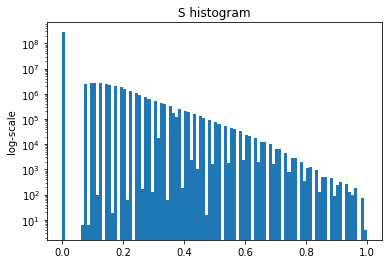

In [57]:
plt.hist(S.flatten(), bins=100)
plt.yscale('log')
plt.title('S histogram')
plt.ylabel('log-scale')
plt.show()

In [58]:
# S_torch = torch.tensor(S_shrinked, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
# S_interp = torch.nn.functional.interpolate(S_torch, size=(n_descr,n_descr)).cpu().numpy()[0,0]
# S_hat = S_interp
# S_hat[S_hat < thr] = 0.
# S_hat[S_hat >= thr] = 1.

In [59]:
# plt.figure(figsize=(10,10), dpi=300)
# plt.plot(np.arange(n)+dt, np.arange(n),'r')
# plt.plot(np.arange(n)-dt, np.arange(n),'r')
# plt.imshow(S_hat)
# plt.show() 

In [60]:
# S_coords_ = coords_@coords_.T

In [61]:
# plt.imshow(S_coords_)

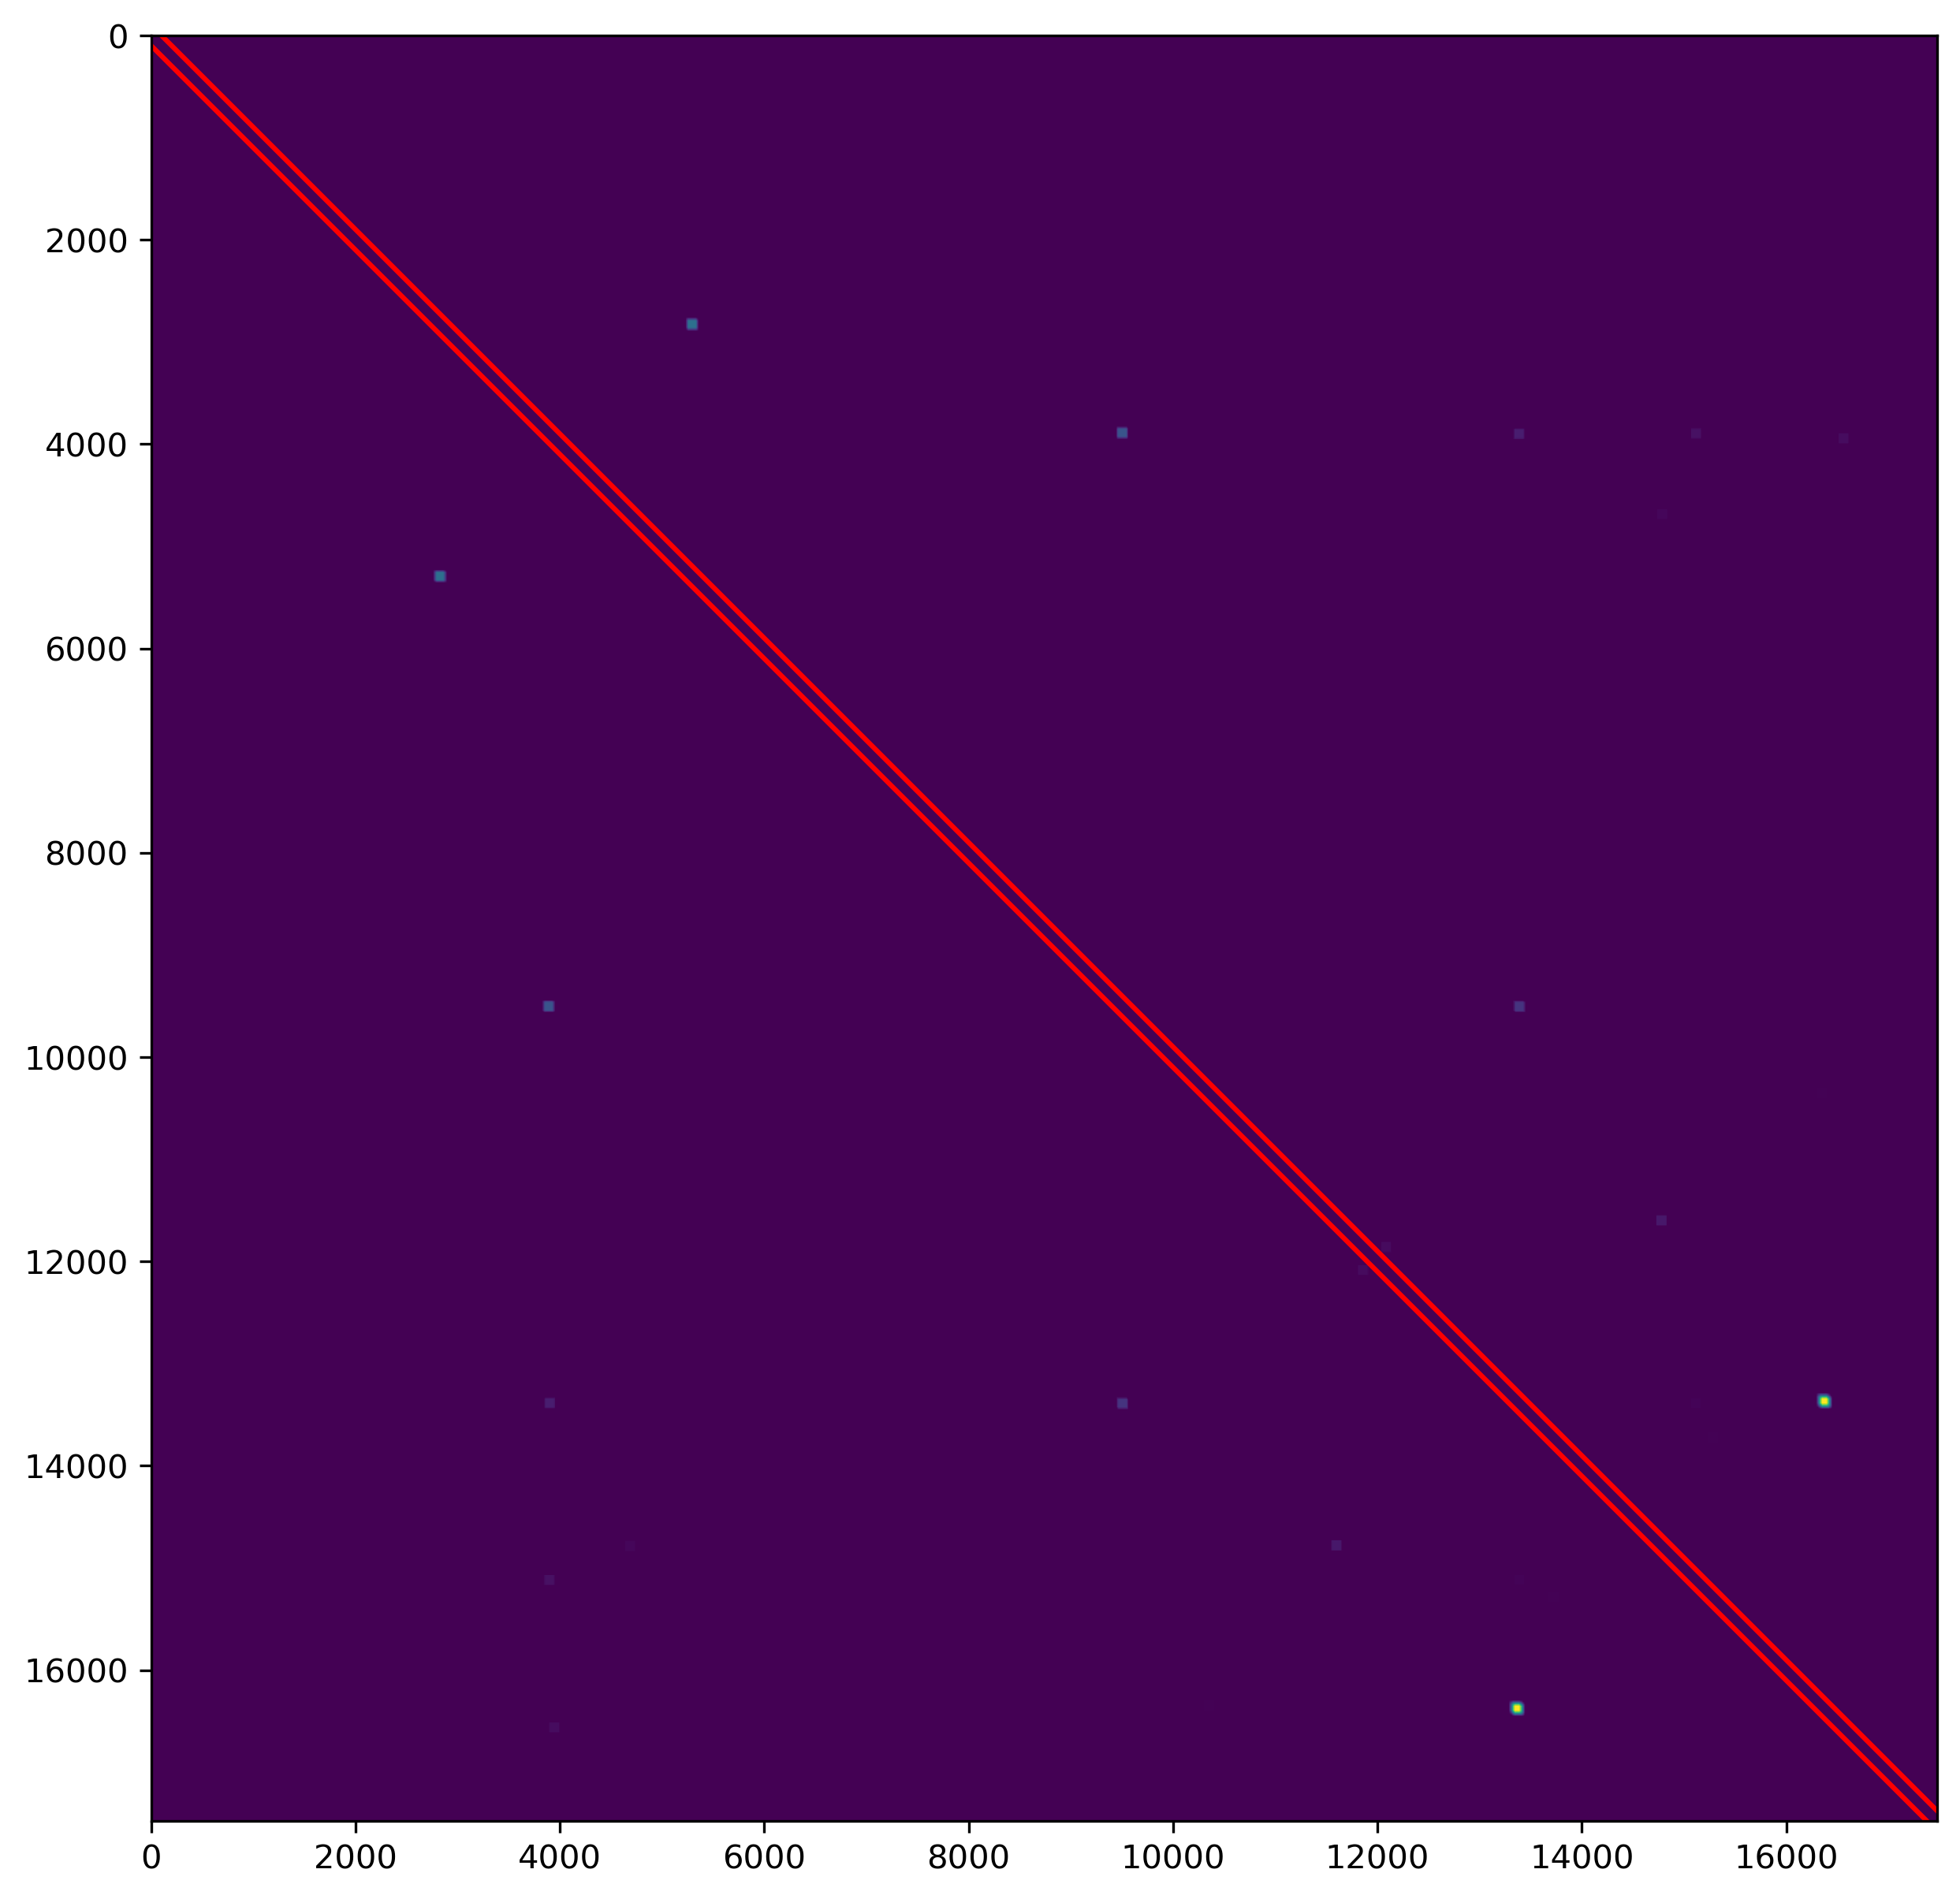

In [62]:
convolve=True
interpolate=False

n = S.shape[0]
S_thresh = S.copy()
thr = 0.9
S_thresh[S_thresh < thr] = 0.
S_thresh[S_thresh >= thr] = 1.

if convolve:
    S_torch = torch.tensor(S_thresh, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
    W_torch = torch.ones((1,1,99,99), dtype=torch.float32).cuda()
    S_hat = torch.conv2d(S_torch, weight=W_torch, padding=49).cpu().numpy()[0,0]
elif interpolate:
    S_torch = torch.tensor(S_shrinked, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
    S_interp = torch.nn.functional.interpolate(S_torch, size=(n_descr,n_descr)).cpu().numpy()[0,0]
    S_hat = S_interp
    S_hat[S_hat < .6] = 0.
    S_hat[S_hat >= .6] = 1.
    S_hat = cv2.medianBlur(S_hat.astype(np.uint8), ksize=71)
    S_hat = cv2.medianBlur(S_hat, ksize=71)
else:
    S_hat = S_thresh

imgname = f'corrmap_{n_descr_start}-{n_descr_start+n_descr}_dil{dilation}_thr{str(thr)[-1]}'
if convolve:
    imgname += '_convolve' 
    
if interpolate:
    imgname += '_interpolate' 
    
plt.figure(figsize=(10,10), dpi=300)
plt.plot(np.arange(n)+dt, np.arange(n),'r')
plt.plot(np.arange(n)-dt, np.arange(n),'r')
plt.title('')
plt.imshow(S_hat)
# plt.savefig('./img/' + imgname + '_' + '_'.join(corr_dir.split('/')[-1].split('_')[1:])  + '_eigformula')
plt.show() 

del S_hat

In [63]:
S_thresh = S.copy()
thr = 0.9
S_thresh[S_thresh < thr] = 0.
S_thresh[S_thresh >= thr] = 1.

time window should not be really high since it produce too diverse correlation pictures

In [64]:
n = S.shape[0]
grid = np.stack(np.meshgrid(np.arange(n), np.arange(n)), -1)
upper_border_mask = grid[:,:,1] > grid[:,:,0] #+ 1.5*dt
lower_border_mask = grid[:,:,1] < grid[:,:,0] #- 1.5*dt
mask = (S_thresh > 0)*(upper_border_mask)

In [65]:
w_ind1, w_ind2 = grid[mask][:,0], grid[mask][:,1]
w_ind = grid[mask]
sim_ind = S[mask]

In [66]:
# number of w_ind 
vis_i = np.arange(len(sim_ind))[np.any(np.abs(np.diff(w_ind, axis=0, prepend=[w_ind[0]])) > 2*dt, axis=1)]

In [67]:
len(vis_i)

31

# Sanity check

0.9001302024996587 True
0.4175249934196472


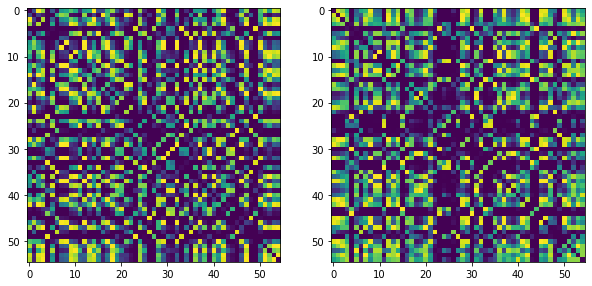

In [68]:
i1 = w_ind1[0]
i2 = w_ind2[0]

print(S[i1, i2], S[i2, i1] == S[i1, i2])

p1 = corr_paths[n_descr_start+i1]
p2 = corr_paths[n_descr_start+i2]

A1 = np.load(p1)
A2 = np.load(p2)

N = A1.shape[0]
non_single_nodes = np.arange(N)[(A1.sum(0)>0)*(A2.sum(0)>0)]
A1_n = A1[non_single_nodes][:,non_single_nodes]
A2_n = A2[non_single_nodes][:,non_single_nodes]

d1 = compute_norm_laplacian_eig(A1_n)
d2 = compute_norm_laplacian_eig(A2_n)

v1 = get_first_k_eig(*d1, k=10) # np.linalg.eig(L2.astype(np.complex64))
v2 = get_first_k_eig(*d2, k=10)

print(1-(np.linalg.norm(v1 - v2, axis=0).mean()/2))

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
axes[0].imshow(A1_n)
axes[1].imshow(A2_n)
plt.show()

# Corresponding coordinates traces

In [90]:
neuronal_groups = []
neuronal_groups_sim_matrix = np.zeros((len(vis_i), len(vis_i)))
for i,k1 in enumerate(vis_i):
    for j,k2 in enumerate(vis_i):
        
        nodes1 = index_to_nodes[w_ind1[k1], w_ind2[k1]]
        nodes2 = index_to_nodes[w_ind1[k2], w_ind2[k2]]

        nodes_sim = len(np.intersect1d(nodes1, nodes2)) / max(len(nodes1), len(nodes2))
        neuronal_groups_sim_matrix[i,j] = nodes_sim
        neuronal_groups_sim_matrix[j,i] = nodes_sim 
        
    neuronal_groups.append(nodes1)
        
# neuronal_groups_sim_matrix[np.diag_indices_from(neuronal_groups_sim_matrix)] = 1

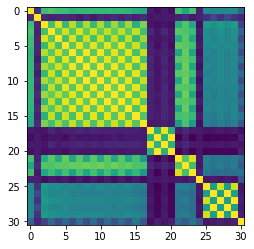

In [70]:
plt.imshow(neuronal_groups_sim_matrix)
plt.show()

# Neuronal groups clustering

In [75]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances

def norm_entropy(x):
    return -(x*np.log(x)).sum() / len(x)
def coord_intersection(c1,c2, bins=25):
    H1,_,_ = np.histogram2d(c1[:,0], c1[:,1], bins=bins, range=[[-1, 1], [-1, 1]], density=True)
    H2,_,_ = np.histogram2d(c2[:,0], c2[:,1], bins=bins, range=[[-1, 1], [-1, 1]], density=True)
    H1 = H1.flatten()/H1.sum()
    H2 = H2.flatten()/H2.sum()
    return H1@H2

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


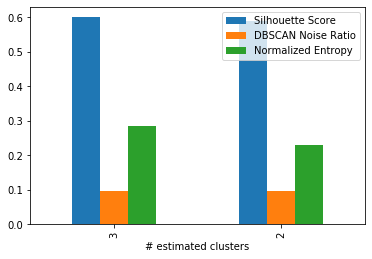

In [72]:
cluster_results = {}
cluster_preds = {}
X=1-neuronal_groups_sim_matrix
param_range = np.linspace(1e-15, 1, 1000)
for p in tqdm_notebook(param_range):
    method = DBSCAN(eps=p, metric='precomputed', min_samples=3, n_jobs=-1, leaf_size=5)
#     method = DBSCAN(eps=p, min_samples=2, n_jobs=-1, leaf_size=5)
    pred = method.fit_predict(X)
    if max(pred) > 0: # at least 2 clusters: [0,1]
        
        silh = silhouette_score(X, pred) # , metric="precomputed"
        unique_clusters = np.unique(pred[pred != -1])
        n = len(unique_clusters)
        
        cl_dist = np.ones(n)
        for i,cl_number in enumerate(unique_clusters):
            cl_dist[i] = sum(pred == cl_number)/len(pred)
        noise_ratio = sum(pred == -1)/len(pred)
        norm_entropy_ = norm_entropy(cl_dist)

        if n in cluster_results:
            # same clustering with lower silhoette score
            if silh < cluster_results[n][0]:
                continue

        cluster_results[n] = [silh, noise_ratio, norm_entropy_] # ,nrs
        cluster_preds[n] = pred
#     else:
#         print('No clusters found')

df = pd.DataFrame(data=cluster_results).T
df.columns = ['Silhouette Score', 'DBSCAN Noise Ratio', 'Normalized Entropy']
df.sort_index(ascending=False, inplace=True)
plt.xlabel('# estimated clusters')
df.plot.bar(ax=plt.gca())
plt.show()

In [95]:
y = cluster_preds[3]
neuronal_clusters = {}
for y_i in np.unique(y[y!=-1]):
    neuronal_clusters[y_i] = [np.sort(neuronal_groups[i]) for i in range(len(neuronal_groups)) if y[i]==y_i]

In [126]:
n_clusters = len(np.unique(y[y!=-1]))

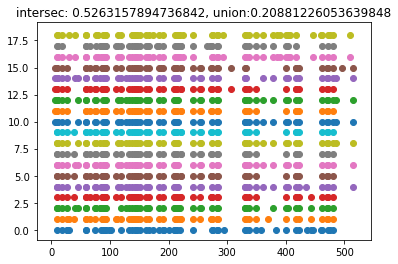

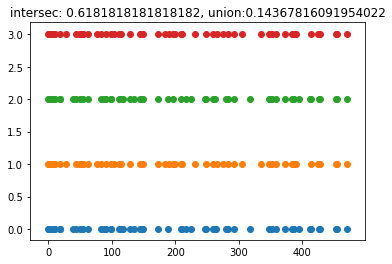

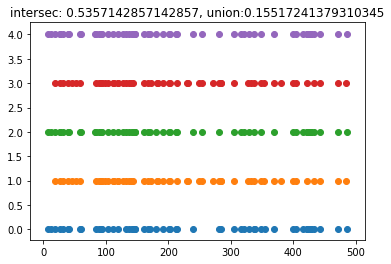

In [109]:
distinct_neuronal_groups_unions = []
distinct_neuronal_groups_intersec = []

for k,v in neuronal_clusters.items():
    plt.figure()
    ng_intersec = v[0]
    ng_union = v[0]
    m = max([len(v_i) for v_i in v])
    for i,v_i in enumerate(v):
        ng_intersec = np.intersect1d(v_i,ng_intersec)
        ng_union = np.unique(np.concatenate([v_i, ng_union]))
        plt.scatter(v_i, [i]*len(v_i))
        plt.title(f'intersec: {len(ng_intersec)/m}, union:{len(ng_union)/N}')
    distinct_neuronal_groups_unions.append(ng_union)
    distinct_neuronal_groups_intersec.append(ng_intersec)
    
    plt.show()
    


In [130]:
def calc_nodes_sim(nodes_list):
    n_ = len(nodes_list)
    ng_S = np.zeros((n_, n_))
    for i in range(n_):
        for j in range(i+1, n_):
            nodes1 = nodes_list[i]
            nodes2 = nodes_list[j]
            ng_S_sim = len(np.intersect1d(nodes1, nodes2)) / max(len(nodes1), len(nodes2))
            ng_S[i,j] = ng_S_sim
            ng_S[j,i] = ng_S_sim
    return ng_S

ng_S_union = calc_nodes_sim(distinct_neuronal_groups_unions)
ng_S_intersec = calc_nodes_sim(distinct_neuronal_groups_intersec)

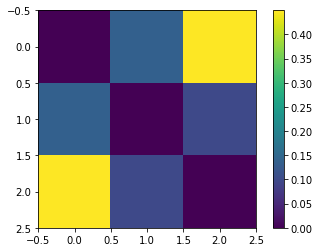

In [132]:
plt.imshow(ng_S_union)
plt.colorbar()
plt.show()

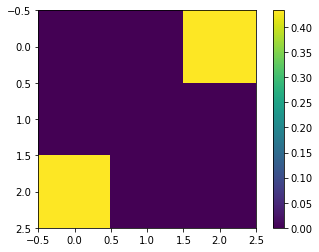

In [133]:
plt.imshow(ng_S_intersec)
plt.colorbar()
plt.show()

In [119]:
# distinct_neuronal_groups_dict = {}
# distinct_neuronal_groups_dict['intersec'] = distinct_neuronal_groups_intersec
# distinct_neuronal_groups_dict['union'] = distinct_neuronal_groups_unions
# distinct_neuronal_groups_dict['all'] = neuronal_groups

# np.save('./corrmap_data/distinct_groups_dict_' + experiment_name + '_eigformula', distinct_neuronal_groups_dict)

In [73]:
# distinct_neuronal_groups = [index_to_nodes[(w_ind1[k], w_ind2[k])] for k in vis_i]

# distinct_neuronal_groups_A = defaultdict(list)
# for group in distinct_neuronal_groups:
#     for vi in vis_i:
#         if group == index_to_nodes[w_ind1[vi], w_ind2[vi]]
#             number = 1000 + w_ind1[vi]
#             A_dng = np.load('./cor')
#             distinct_neuronal_groups[group].append(A_dng)

In [123]:
ng_union_all = distinct_neuronal_groups_unions[0]
for ng_u in distinct_neuronal_groups_unions:
    ng_union_all = np.unique(np.concatenate([ng_union_all, ng_u]))
print(len(ng_union_all))

198


/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


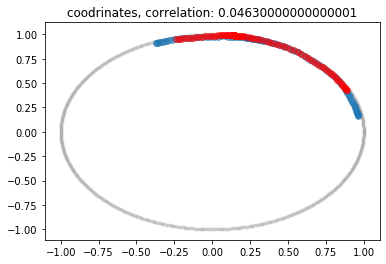

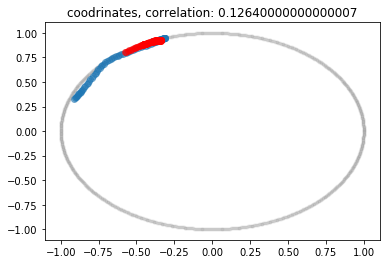

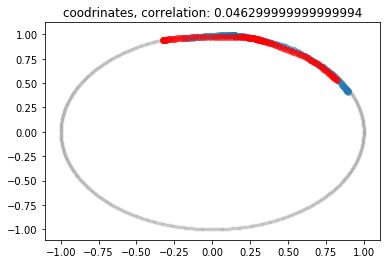

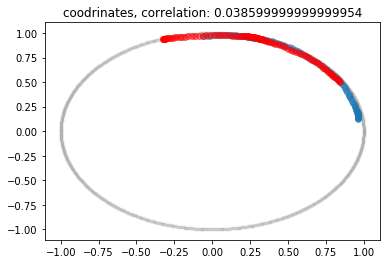

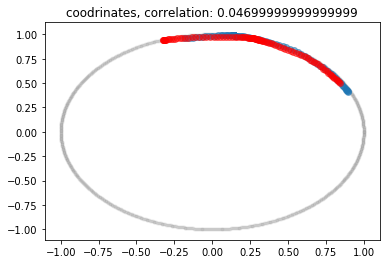

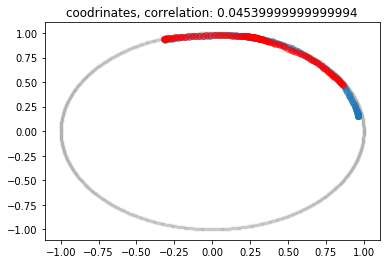

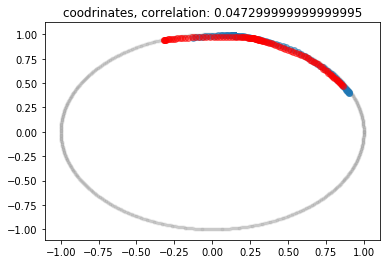

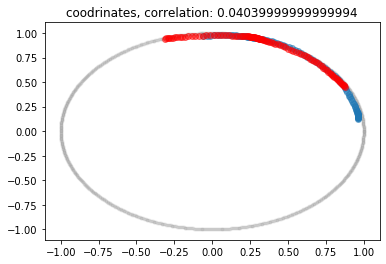

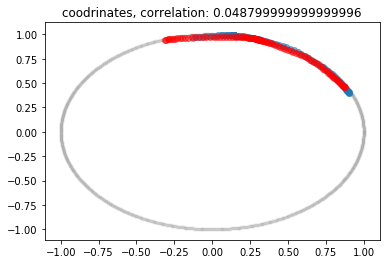

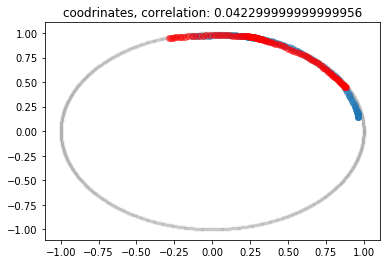

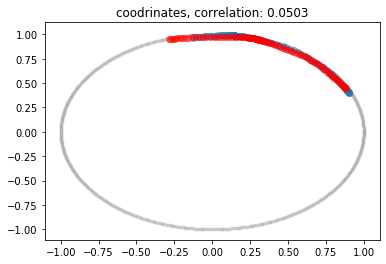

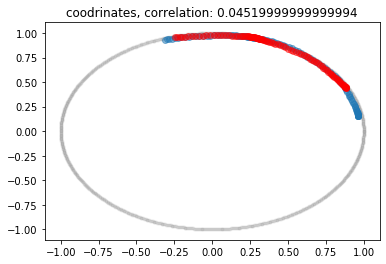

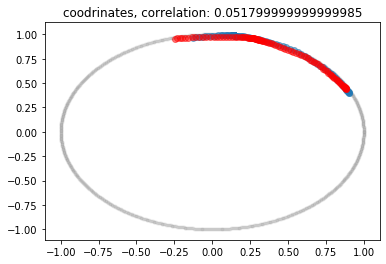

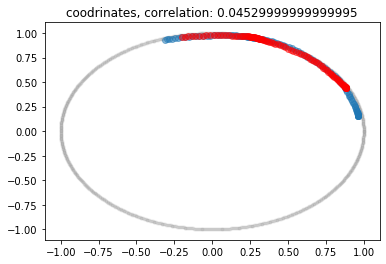

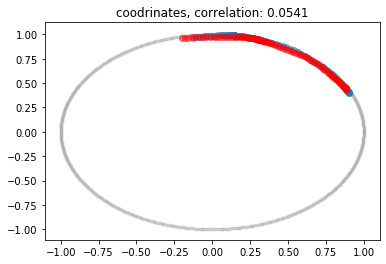

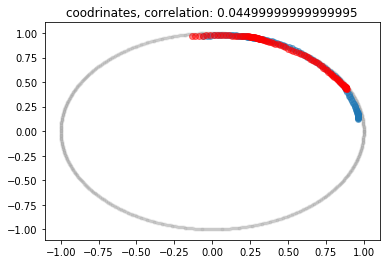

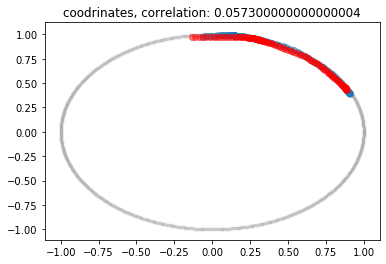

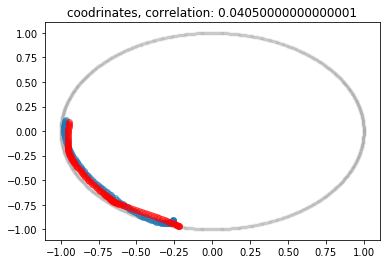

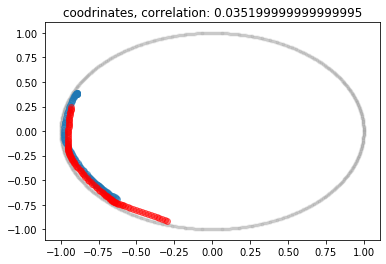

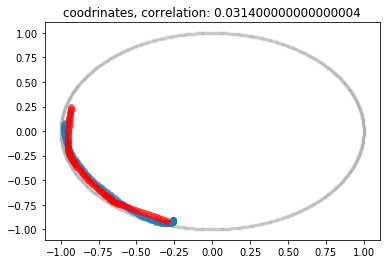

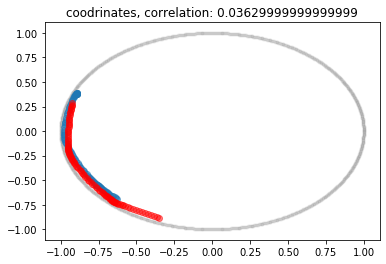

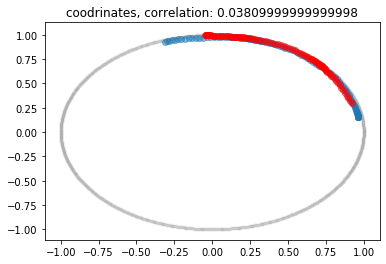

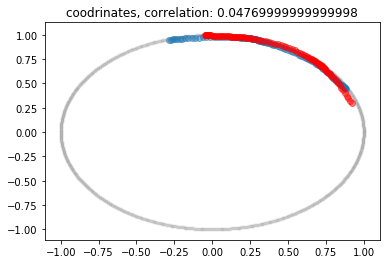

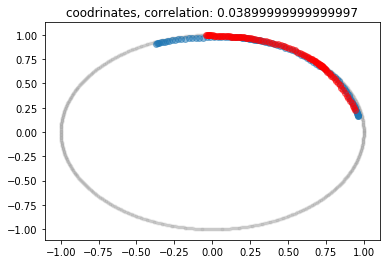

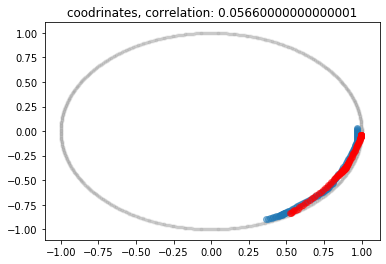

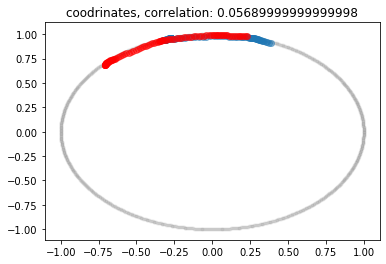

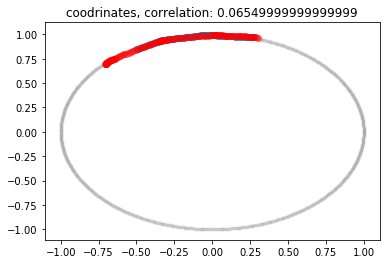

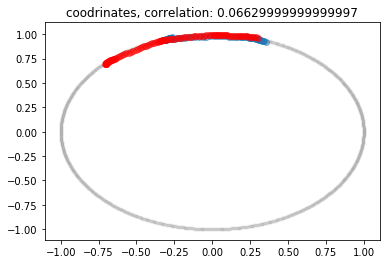

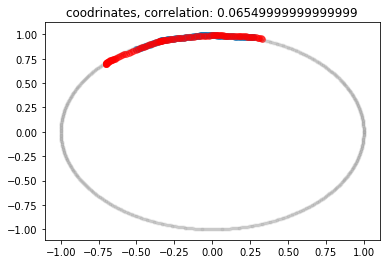

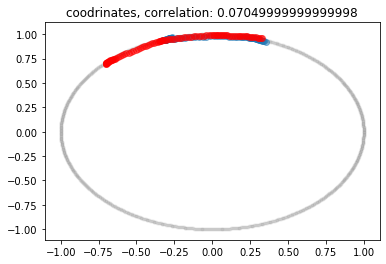

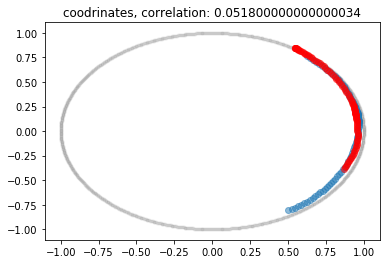

In [76]:
for k in vis_i:
    wi1, wi2 = w_ind1[k], w_ind2[k]
    coords_subset1 = coords_[n_descr_start:n_descr_start+n_descr][wi1:wi1+dt]
    coords_subset2 = coords_[n_descr_start:n_descr_start+n_descr][wi2:wi2+dt]
    ci = coord_intersection(coords_subset1, coords_subset2)
    if ci > 0.0:
#         print(ci)
        plt.figure()
        angle_range = np.linspace(0, 2*np.pi, 1000)
        plt.scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')
        plt.scatter(coords_subset1[:,0], coords_subset1[:,1], label='neural group correlation', alpha=0.5)
        plt.scatter(coords_subset2[:,0], coords_subset2[:,1], label='neural group correlation', color='r', alpha=0.5)
        plt.title(f'coodrinates, correlation: {ci}')
        
#         axes[1].plot(speed_subset,color='grey',alpha=0.5)
#         axes[1].plot(speed_subset_masked1, label='neural group correlation')
#         axes[1].plot(speed_subset_masked2, label='neural group correlation', color='r')
#         axes[1].set_title('speed')

#         axes[2].plot(acc_subset,color='grey',alpha=0.5)
#         axes[2].plot(acc_subset_masked1, label='neural group correlation')
#         axes[2].plot(acc_subset_masked2, label='neural group correlation', color='r')
#         axes[2].set_title('acceleration')

In [288]:
# distinct_neuronal_groups 

In [ ]:
# np.save('corrmap_data/distinct_neuronal_groups_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7_eigformula_thr_50', distinct_neuronal_groups)

In [309]:
# group_to_index = [vis_i[distinct_neuronal_groups_mask]]

In [289]:
# A_s = Parallel(n_jobs=-1)(delayed(np.load)(p) for p in tqdm_notebook(corr_paths[n_descr_start:n_descr_start+n_descr]))
# A_s = np.stack(A_s, 0)

In [290]:
# neural_group_timesteps = []
# for i1,i2 in grid[mask]:
#     if len(np.intersect1d(index_to_nodes[(i1,i2)], neural_group))/min(len(index_to_nodes[(i1,i2)]),len(neural_group)) > 0.8:
#         neural_group_timesteps.append(i1)
#         neural_group_timesteps.append(i2)       

# neural_group_timesteps = np.unique(neural_group_timesteps)
# neural_group_timesteps

In [ ]:
# n_vis = 2 #np.floor(np.sqrt(len(vis_i))).astype(int)
# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(5*n_vis,5*n_vis))


# for i,ax in enumerate(axes.flatten()):
#     try:
#         k = vis_i[neuronal_groups_sim_matrix.sum(0) < 13][i]
#         i1,i2 = w_ind1[k], w_ind2[k]
#         i1 += n_descr_start
#         i2 += n_descr_start
#         c1 = coords_[i1:i1+dt,:]
#         c2 = coords_[i2:i2+dt,:]
        
#         r1 = int(rears_indicators[i1:i1+dt].sum() > 0)
#         r2 = int(rears_indicators[i2:i2+dt].sum() > 0)
        
#         angle_range = np.linspace(0, 2*np.pi, 1000)
#         ax.scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')
#         ax.scatter(c1[:,0], c1[:,1],color='b', alpha=0.1)
#         ax.scatter(c2[:,0], c2[:,1],color='r', alpha=0.1)
#         ax.set_title(f'sim: {sim_ind[k]}, \n blue: {i1}, red: {i2}, \n neuronal group: {i}, size: {len(index_to_nodes[w_ind1[k], w_ind2[k]])}, \n rear1:{r1},  rear2:{r2}')
#         ax.set_ylim(-1.1, 1.1)
#         ax.set_xlim(-1.1, 1.1)
#     except:
#         pass
    
# plt.tight_layout()
# plt.savefig('./img/' + 'coords' + '_'.join(corr_dir.split('/')[-1].split('_')[1:]) + '_eigformula')
# plt.show()

# Corresponding speed\acceleration

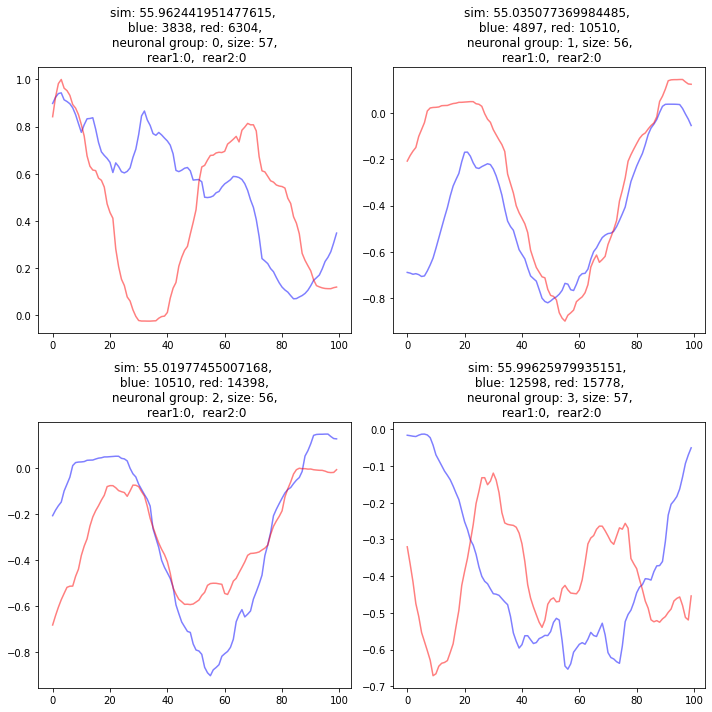

In [115]:
n_vis = 2 #np.floor(np.sqrt(len(vis_i))).astype(int)
fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(5*n_vis,5*n_vis))

for i,ax in enumerate(axes.flatten()):
    try:
        k = vis_i[neuronal_groups_sim_matrix.sum(0) < 13][i]
        i1,i2 = w_ind1[k], w_ind2[k]
        i1 += n_descr_start
        i2 += n_descr_start
        v1 = speed_[i1:i1+dt]
        v2 = speed_[i2:i2+dt]
        
        r1 = int(rears_indicators[i1:i1+dt].sum() > 0)
        r2 = int(rears_indicators[i2:i2+dt].sum() > 0)
        
        ax.plot(v1,color='b', alpha=0.5)
        ax.plot(v2,color='r', alpha=0.5)
        ax.set_title(f'sim: {sim_ind[k]}, \n blue: {i1}, red: {i2}, \n neuronal group: {i}, size: {len(index_to_nodes[w_ind1[k], w_ind2[k]])}, \n rear1:{r1},  rear2:{r2}')
    except:
        pass
    
plt.tight_layout()
plt.savefig('./img/' + 'speed' + '_'.join(corr_dir.split('/')[-1].split('_')[1:]))
plt.show()

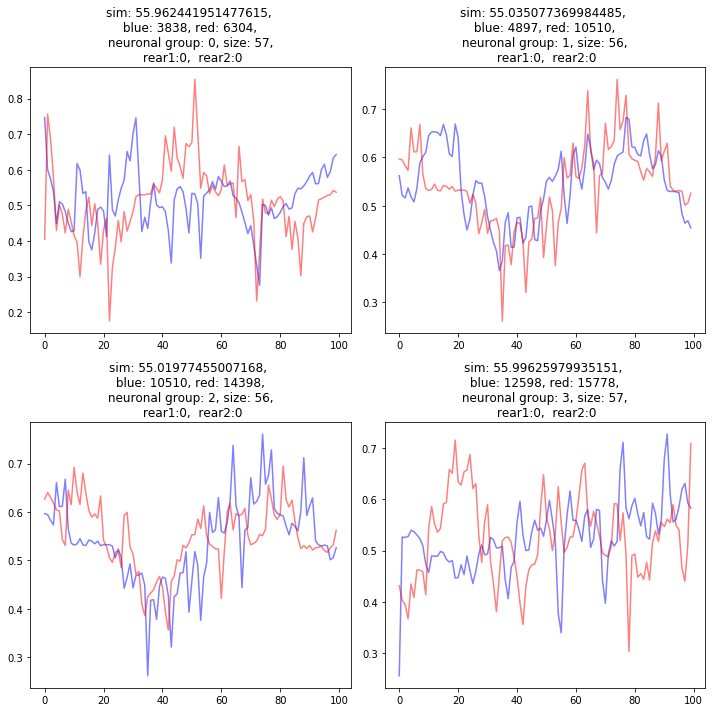

In [116]:
n_vis = 2 #np.floor(np.sqrt(len(vis_i))).astype(int)
fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(5*n_vis,5*n_vis))

for i,ax in enumerate(axes.flatten()):
    try:
        k = vis_i[neuronal_groups_sim_matrix.sum(0) < 13][i]
        i1,i2 = w_ind1[k], w_ind2[k]
        i1 += n_descr_start
        i2 += n_descr_start
        v1 = acceleration_[i1:i1+dt]
        v2 = acceleration_[i2:i2+dt]
        
        r1 = int(rears_indicators[i1:i1+dt].sum() > 0)
        r2 = int(rears_indicators[i2:i2+dt].sum() > 0)
        
        ax.plot(v1,color='b', alpha=0.5)
        ax.plot(v2,color='r', alpha=0.5)
        ax.set_title(f'sim: {sim_ind[k]}, \n blue: {i1}, red: {i2}, \n neuronal group: {i}, size: {len(index_to_nodes[w_ind1[k], w_ind2[k]])}, \n rear1:{r1},  rear2:{r2}')

    except:
        pass
    
plt.tight_layout()
plt.savefig('./img/' + 'acceleration' + '_'.join(corr_dir.split('/')[-1].split('_')[1:]))
plt.show()

In [84]:
# c1_vis_all = []
# c2_vis_all = []
# ls = []
# for i,k in enumerate(vis_i):
#     i1,i2 = w_ind1[k], w_ind2[k]
    
#     l1 = i1/n_descr
#     l2 = i2/n_descr

#     i1 += n_descr_start
#     i2 += n_descr_start
    
#     c1 = coords_[i1:i1+dt,:]*l1
#     c2 = coords_[i2:i2+dt,:]*l2
    
#     c1_vis_all.append(c1)
#     c2_vis_all.append(c2)
    
#     ls.append(l1)
#     ls.append(l2)
    
# c1_vis_all = np.concatenate(c1_vis_all, 0)
# c2_vis_all = np.concatenate(c2_vis_all, 0)

# plt.figure(figsize=(10,10), dpi=200)
# angle_range = np.linspace(0, 2*np.pi, 1000)
# for l in sorted(np.linspace(0,1,10)):
#     plt.scatter(np.cos(angle_range)*l, np.sin(angle_range)*l,color='grey', alpha=0.1, marker='.', s=1)
# plt.scatter(c1_vis_all[:,0], c1_vis_all[:,1] ,color='b', alpha=0.1, s=2)
# plt.scatter(c2_vis_all[:,0], c2_vis_all[:,1] ,color='r', alpha=0.1, s=2)
# plt.show()

# 1d similarity map

In [661]:
# A_s = Parallel(n_jobs=20)(delayed(np.load)(p) for p in tqdm_notebook(corr_paths[n_descr_start:n_descr_start+n_descr]))
# A_s = np.stack(A_s, 0)

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [1262]:
def A_s_group_diff(i): # A_s_group
    A_s_group = A_s[i:i+kernel_size_clustering].copy()
    mask = A_s_group[0].sum(0) > 0
    N = A_s_group[0].shape[0]
    for A_i in A_s_group[1:]:
        mask *= A_i.sum(0) > 0
    
    non_single_nodes = np.arange(N)[mask]
    
    if len(non_single_nodes) >= 5:
        vi_s = []
        for A_i in A_s_group:

            A_i = A_i[non_single_nodes][:,non_single_nodes]
            d = compute_norm_laplacian_eig(A_i)
            vi_s.append(get_first_k_eig(*d, k=10))
            
        vi_s = np.stack(vi_s)
        
        return 1-np.linalg.norm(vi_s.var(0), axis=0).mean()
    else:
        return 0

In [1271]:
# A_s_group_diffs = Parallel(n_jobs=1)(delayed(A_s_group_diff)(i) for i in tqdm_notebook(range(len(A_s) - kernel_size_clustering)))

# A_s_group_diffs =[]

# for i in tqdm_notebook(range(len(A_s) - kernel_size_clustering)):
#     A_s_group_diffs.append(A_s_group_diff(i))
    
# A_s_group_diffs = np.array(A_s_group_diffs)

In [1272]:
# plt.plot(-(A_s_group_diffs - 1)[:1000])

# Create labyrinth parts graph

In [612]:
# n_places = 10
# places_boundaries = np.linspace(0, 2*np.pi, n_places+1)

In [613]:
# places_graph = nx.Graph()
# places_graph.add_nodes_from([(i, {"boundaries": (places_boundaries[i], places_boundaries[i+1])}) \
#                              for i in range(n_places)])

In [1214]:
# def coords2places(coords, places_boundaries, thresh=15):
#     places = []
#     phi = np.arctan2(coords[:,0], coords[:,1])+np.pi
#     for i in range(len(places_boundaries)-1):
#         p1,p2 = places_boundaries[[i,i+1]]
#         mask = (phi <= p2)*(phi >= p1)
#         if mask.sum() > thresh:
#             places.append(i)
#     return places

In [1215]:
# plt.figure(figsize=(5,5), dpi=200)
# places_boundaries_coords = np.stack([np.cos(places_boundaries), np.sin(places_boundaries)], 1)
# plt.scatter(places_boundaries_coords[:,0], places_boundaries_coords[:,1], color='blue', alpha=0.7, marker='.')
# plt.scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')

# for i,k in enumerate(vis_i):
#     i1,i2 = w_ind1[k], w_ind2[k]
    
#     i1 += n_descr_start
#     i2 += n_descr_start
    
#     c1 = coords_[i1:i1+dt,:]
#     c2 = coords_[i2:i2+dt,:]
    
#     sim_ = sim_ind[i]
     
#     places1 = coords2places(c1, places_boundaries, thresh=15)
#     places2 = coords2places(c2, places_boundaries, thresh=15)

#     for edge in list(product(places1, places2)):
#         places_graph.add_edge(*edge)
#         v1,v2 = edge
#         c1,c2 = np.mean(places_boundaries[[v1,v1+1]]), np.mean(places_boundaries[[v2,v2+1]])
            
#         plt.plot([np.cos(c1), np.cos(c2)], \
#                  [np.sin(c1), np.sin(c2)],color='black', alpha=sim_/2)

# plt.ylim(-1.1, 1.1)
# plt.xlim(-1.1, 1.1)
# plt.show()

# Extend to the consecutive days

In [23]:
ls -la ./corrmap_data/

total 19700968
drwxrwxr-x 10 ibulygin ibulygin        4096 май 24 21:50 ./
drwxrwx--- 18 ibulygin ibulygin        4096 июн  2 13:23 ../
-rw-rw-r--  1 ibulygin ibulygin         128 апр  7 18:45 corrmap_result_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7.npy
drwxrwxr-x  2 ibulygin ibulygin        4096 май 24 21:45 corrmaps_Circle_M22_D1_dt1000_exponential_TRISE15_TOFF40/
drwxrwxr-x  2 ibulygin ibulygin      507904 мар 20 15:06 corrmaps_Circle_M22_D1_dt1000_kernel400_exponential_TRISE15_TOFF40/
drwxrwxr-x  2 ibulygin ibulygin      528384 апр  6 17:40 corrmaps_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7/
drwxrwxr-x  2 ibulygin ibulygin      528384 апр  2 00:48 corrmaps_Circle_M22_D1_dt250_kernel150_TRISE10_TOFF30/
drwxrwxr-x  2 ibulygin ibulygin      520192 мар 24 15:09 corrmaps_Circle_M22_D1_dt500_kernel250_exponential_TRISE10_TOFF40/
drwxrwxr-x  2 ibulygin ibulygin      507904 апр 19 14:44 corrmaps_Circle_M22_D2_dt100_kernel49_gaussian_SYGMA7/
drwxrwxr-x  2 ibulygin ibulygin      135168

In [28]:
corr_dir1 = './corrmap_data/corrmaps_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7'
corr_dir2 = './corrmap_data/corrmaps_Circle_M22_D2_dt100_kernel49_gaussian_SYGMA7'

corr_paths1 = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])
corr_paths2 = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])